In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import subprocess
import os
import glob

from scipy.special import erf
import scipy.optimize as opt
from matplotlib.ticker import FixedLocator
from scipy.stats import norm
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


import matplotlib
import pickle


# Define the 2D Gaussian function
def gaussian_2d(X, A, x0, y0, sigma_x, sigma_y):
    x, y = X  # X is a tuple (x, y)
    return (A * np.exp(-(((x - x0) ** 2) / (2 * sigma_x ** 2) + ((y - y0) ** 2) / (2 * sigma_y ** 2)))).ravel()
# Define 1D Gaussian function
def gaussian_1d(y, A, y0, sigma_y):
    return A * np.exp(-((y - y0) ** 2) / (2 * sigma_y ** 2))

def check_bins_2D(ax):
    image =  ax.collections[0]  # The QuadMesh object
    x_edges = image._coordinates[0]  # Bin edges along X-axis
    y_edges = image._coordinates[1]  # Bin edges along Y-axis

    # Compute bin widths
    retrieved_bin_width_x = x_edges[1] - x_edges[0]
    retrieved_bin_width_y = y_edges[1] - y_edges[0]

    # Print results

    print(f"Retrieved bin width (X): {retrieved_bin_width_x}")
    print(f"Retrieved bin width (Y): {retrieved_bin_width_y}")

In [3]:
! ls /eos/home-c/cmaccani/DoubleChannelingFiles

Double_Channeling_450_TCCP_0.0.h5    Double_Channeling_450_TCCP_19.8.h5
Double_Channeling_450_TCCP_-11.0.h5  Double_Channeling_450_TCCP_-20.9.h5
Double_Channeling_450_TCCP_11.0.h5   Double_Channeling_450_TCCP_-22.0.h5
Double_Channeling_450_TCCP_-1.1.h5   Double_Channeling_450_TCCP_-2.2.h5
Double_Channeling_450_TCCP_1.1.h5    Double_Channeling_450_TCCP_2.2.h5
Double_Channeling_450_TCCP_-12.1.h5  Double_Channeling_450_TCCP_-3.3.h5
Double_Channeling_450_TCCP_12.1.h5   Double_Channeling_450_TCCP_3.3.h5
Double_Channeling_450_TCCP_-13.2.h5  Double_Channeling_450_TCCP_-4.4.h5
Double_Channeling_450_TCCP_13.2.h5   Double_Channeling_450_TCCP_4.4.h5
Double_Channeling_450_TCCP_-14.3.h5  Double_Channeling_450_TCCP_-5.5.h5
Double_Channeling_450_TCCP_14.3.h5   Double_Channeling_450_TCCP_5.5.h5
Double_Channeling_450_TCCP_-15.4.h5  Double_Channeling_450_TCCP_-6.6.h5
Double_Channeling_450_TCCP_15.4.h5   Double_Channeling_450_TCCP_6.6.h5
Double_Channeling_450_TCCP_-16.5.h5  Double_Channeling_450_TCCP_-7.

In [4]:
dc_files_path  = "/eos/home-c/cmaccani/DoubleChannelingFiles"

In [5]:
def plot_rectangle( ax, x_low, x_up, y_low, y_up, zorder = 100, linewidth = 1, edgecolor = 'r', facecolor='none', alpha=1):
    rect = matplotlib.patches.Rectangle((x_low, y_low), x_up - x_low, y_up - y_low, edgecolor=edgecolor, facecolor=facecolor, alpha = alpha, zorder=zorder, linewidth=linewidth)
    ax.add_patch(rect)
    
RPX_bottom_wall_thickess = 2.14e-3

def get_pentagonal(y_lim = 0.003):
    angles = [180-135, 90, 90, 90,135] 
    side_lengths = [31.1e-3, 10e-3, 32e-3, 32e-3, 10e-3]  
    angles = np.radians(angles)

    ALFA_x = [0]
    ALFA_y = [0]
    for i in range(len(side_lengths)):
        angle_sum = np.sum(angles[:i])
        ALFA_x.append(ALFA_x[-1] + side_lengths[i] * np.cos(angle_sum))
        ALFA_y.append(ALFA_y[-1] + side_lengths[i] * np.sin(angle_sum))
    # Close the pentagon by appending the first vertex at the end
    ALFA_x.append(ALFA_x[0])
    ALFA_y.append(ALFA_y[0])

    # Center in x an apply vertical offset
    ALFA_x = [i -side_lengths[0]/2 for i in ALFA_x]
    ALFA_y = [i + y_lim for i in ALFA_y]

    return np.array(ALFA_x), np.array(ALFA_y)

def get_intersections(jaw_L, ALFA_x, ALFA_y, y_horizontal = None, RPX_bottom_wall_thickess = 2.14e-3):

    y_horizontal = jaw_L + RPX_bottom_wall_thickess if y_horizontal is None else y_horizontal

    pentagon = []
    for i, j in zip(ALFA_x, ALFA_y):
        pentagon.append([i, j])

    intersections = []
   
    # Function to find the intersection between a horizontal line and a line segment
    def find_intersection(p1, p2, y_horizontal):
        x1, y1 = p1
        x2, y2 = p2
        
        # Check if the line segment intersects the horizontal line
        if (y1 - y_horizontal) * (y2 - y_horizontal) <= 0:
            # Calculate the intersection point
            if y1 != y2:
                x_intersect = x1 + (x2 - x1) * (y_horizontal - y1) / (y2 - y1)
                return (x_intersect, y_horizontal)
        return None

    for i in range(len(pentagon)):
        p1 = pentagon[i]
        p2 = pentagon[(i + 1) % len(pentagon)]
        intersection = find_intersection(p1, p2, y_horizontal)
        if intersection:
            intersections.append(intersection)

    return intersections

def plot_simulations_TFT(fig, ax_or_spec, x, y, jaw_L, abs_y_low, vmin=None, vmax=None, print_vmax=False, n_sigma=5.5,
                         sigma_line=False, n_ticks=2, log_norm=True, plot_fit=False, fit = False,
                         plot_max_dot=False, plot_cbar=True, print_count=True, return_fit=False, add_box=False):
    
    if isinstance(ax_or_spec, matplotlib.gridspec.SubplotSpec):
        inner_gs = matplotlib.gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=ax_or_spec, width_ratios=[0.80, 0.03], wspace=0.17) 
    else:
        ax_or_spec = matplotlib.gridspec.GridSpec(1, 1, figure=fig)
        inner_gs = matplotlib.gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=ax_or_spec[0], width_ratios=[0.80, 0.03], wspace=0.17)

    ax = fig.add_subplot(inner_gs[0])
    ax_cb = fig.add_subplot(inner_gs[1])
    ALFA_x, ALFA_y = get_pentagonal(y_lim=jaw_L + 500e-6)
    ax.plot(ALFA_x, ALFA_y, color='r', lw=2)
    xlim = [min(np.min(ALFA_x) - 1e-3, min(x)), max(np.max(ALFA_x) + 1e-3, max(x))]
    ylim = [min(jaw_L, min(y)), max(np.max(ALFA_y) + 1e-3, max(y))]

    ax.set_xlabel("x [mm]", fontsize=14)
    ax.set_ylabel("y [mm]", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(linestyle=":")

    alfa_resolution = 30e-6
    bins_x = round((xlim[1] - xlim[0]) / alfa_resolution)
    bins_y = round((ylim[1] - ylim[0]) / alfa_resolution)

    cmap = plt.cm.viridis.copy()
    cmap.set_under('white')
    norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax) if log_norm else matplotlib.colors.Normalize(vmin=1e-5)
    h = ax.hist2d(x, y, norm=norm, bins=[bins_x, bins_y], range=[xlim, ylim], cmap=cmap)

    if print_vmax:
        norm.autoscale(h[0])
        print('vmax: ', norm.vmax)

    x_centers = (h[1][:-1] + h[1][1:]) / 2
    y_centers = (h[2][:-1] + h[2][1:]) / 2

    filtered_hist = h[0].copy()
    for j, y_center in enumerate(y_centers):
        if y_center < abs_y_low:
            filtered_hist[:, j] = -np.inf

    max_count = np.max(filtered_hist)
    max_index = np.unravel_index(np.argmax(filtered_hist), h[0].shape)
    max_bin_x = (h[1][max_index[0]] + h[1][max_index[0] + 1]) / 2
    max_bin_y = (h[2][max_index[1]] + h[2][max_index[1] + 1]) / 2

    n_impacts = len(y[y > abs_y_low])
    if plot_max_dot:
        ax.plot(max_bin_x, max_bin_y, 'ro', markersize=2)
        print(f"The bin with the highest value is at ({max_bin_x:.6f}, {max_bin_y:.6f}) with a count of {max_count}.")
        print(f'Total impacts: {n_impacts}, max count normalized by total impacts: {max_count/n_impacts:.5f}')

    ax.set_xticks(ticks=ax.get_xticks(), labels=[f"{x_tick*1e3:.1f}" for x_tick in ax.get_xticks()])
    ax.set_yticks(ticks=ax.get_yticks(), labels=[f"{y_tick*1e3:.1f}" for y_tick in ax.get_yticks()])

    ALFA_x, ALFA_y = get_pentagonal(y_lim=jaw_L + 200e-6)
    intersections = get_intersections(jaw_L, ALFA_x, ALFA_y)
    ax.plot(ALFA_x, ALFA_y, 'grey', linewidth=2)
    ax.axhline(jaw_L, color='grey', linestyle='-', zorder=10)
    ax.plot([xlim[0], intersections[1][0]], [jaw_L + RPX_bottom_wall_thickess] * 2, color='grey', linestyle='-', zorder=10)
    ax.plot([intersections[0][0], xlim[1]], [jaw_L + RPX_bottom_wall_thickess] * 2, color='grey', linestyle='-', zorder=10)

    if plot_cbar:
        cbar = fig.colorbar(h[3], cax=ax_cb, orientation='vertical')
        if print_count:
            cbar.set_label('Counts', fontsize=14)
        cbar.ax.tick_params(labelsize=12)

    ax.grid(linestyle=':')
    if fit:
        X, Y = np.meshgrid(x_centers, y_centers, indexing='ij')
        xdata = np.vstack((X.ravel(), Y.ravel()))
        zdata = h[0].ravel()

        def gaussian_2d(coords, amp, x0, y0, sigma_x, sigma_y, offset):
            x, y = coords
            return amp * np.exp(-(((x - x0) ** 2) / (2 * sigma_x ** 2) + ((y - y0) ** 2) / (2 * sigma_y ** 2))) + offset

        initial_guess = (np.max(zdata), np.mean(x), np.mean(y), np.std(x), np.std(y), 0)
        popt, pcov = curve_fit(gaussian_2d, xdata, zdata, p0=initial_guess)
        fit_data = gaussian_2d((X, Y), *popt)
        perr = np.sqrt(np.diag(pcov))

        fit_df = pd.DataFrame({"Parameter": ["amplitude", "x0", "y0", "sigma_x", "sigma_y", "offset"],
                            "Value": popt,
                            "StdError": perr})
        print(fit_df)

        if plot_fit:
            ax.plot(popt[1], popt[2], 'ro', markersize=2, label='Gaussian Fit Center')
            ellipse = matplotlib.patches.Ellipse((popt[1], popt[2]), width=6*popt[3], height=6*popt[4],
                                                edgecolor='g', facecolor='none', linewidth=2, zorder=4)
            ax.add_patch(ellipse)



        if add_box:
            legend_text = f"Fit center: ({popt[1]*1e3:.2f}, {popt[2]*1e3:.2f}) mm\nFit sigma: ({popt[3]*1e3:.2f}, {popt[4]*1e3:.2f}) mm"
            ax.text(0.95, 0.95, legend_text, ha="right", va="top", transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))
            

        if return_fit:
            return fit_df
        
    ax_tw = ax.twinx()
    ref = 0
    sigma_abs = jaw_L / n_sigma
    ax_tw.set_ylim((ax.get_ylim()[0]-ref)/sigma_abs, (ax.get_ylim()[1]-ref)/sigma_abs)
    yticks = np.arange(np.ceil(ax_tw.get_ylim()[0]), np.floor(ax_tw.get_ylim()[1]) + 1, n_ticks)
    ax_tw.set_yticks(yticks)
    ax_tw.set_ylabel(r' n $\sigma$', fontsize=14)
    ax_tw.tick_params(axis='both', which='major', labelsize=12)
    if sigma_line:
        ax_tw.axhline(n_sigma, color='r', linestyle='--')
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_xlim(xlim[0], xlim[1])


In [6]:
df_TFT = pd.read_hdf(f"{dc_files_path}/Double_Channeling_450_TCCP_0.0.h5", key = "TFT_data" )
df_PIX = pd.read_hdf(f"{dc_files_path}/Double_Channeling_450_TCCP_0.0.h5", key = "PIXEL_data" )
metadata = pd.read_hdf(f"{dc_files_path}/Double_Channeling_450_TCCP_0.0.h5", key = "metadata" )

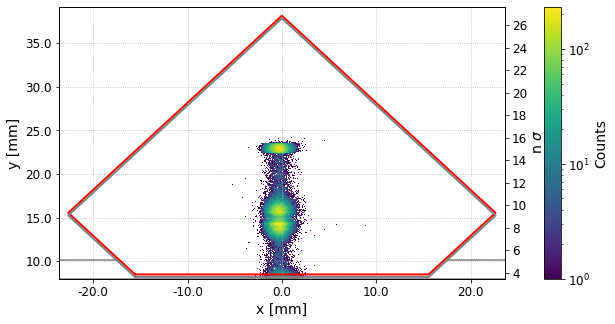

In [7]:
fig = plt.figure(figsize=(9, 5))
#x = fig.add_subplot(111)
x = df_TFT["x"]
y = df_TFT["y"]
jaw_L = 5.5 *0.0014479740312245593 #+ RPX_bottom_wall_thickess 
abs_y_low = jaw_L #+ 500e-6
plot_simulations_TFT(fig, None, x, y, jaw_L, abs_y_low, return_fit=True, add_box=True,)

In [8]:
def get_TFT_array(df_TFT, show_plot = True):
    x = df_TFT["x"]
    y = df_TFT["y"]
    jaw_L = 5.5 *0.0014479740312245593 #+ RPX_bottom_wall_thickess 
    abs_y_low = jaw_L #+ 500e-6

    fig, ax = plt.subplots(figsize=(23/2, 35/4))
    vmax, vmin = None, None
    ALFA_x, ALFA_y = get_pentagonal(y_lim= jaw_L + 0.003)
    ax.plot(ALFA_x, ALFA_y, color='r', lw=2)
    xlim = [-0.023, 0.023] #[min(np.min(ALFA_x) - 1e-3, min(x)), max(np.max(ALFA_x) + 1e-3, max(x))]
    ylim = [jaw_L, jaw_L+0.035]#[min(jaw_L, min(y)), max(np.max(ALFA_y) + 1e-3, max(y))]

    ax.set_xlabel("x [mm]", fontsize=14)
    ax.set_ylabel("y [mm]", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(linestyle=":")

    alfa_resolution = 30e-6
    bins_x = 1500 #round((xlim[1] - xlim[0]) / alfa_resolution)
    bins_y = 1500 #round((ylim[1] - ylim[0]) / alfa_resolution)

    cmap = plt.cm.viridis.copy()
    cmap.set_under('white')
    norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax) 
    h_TFT = ax.hist2d(x, y, norm=norm, bins=[bins_x, bins_y], range=[xlim, ylim], cmap=cmap)
    check_bins_2D(ax)
    if show_plot:
        plt.show()
    else:
        plt.close(fig)
    return h_TFT
   

In [9]:
def get_PIX_array(df_PIX, show_plot=True):
    x_df = df_PIX["x"]
    y_df = df_PIX["y"]
    PIX_y_distance_to_RPX = 0.00314
    ydim=0.01408
    xdim=0.04224
    f = 500
    fig, ax = plt.subplots(figsize=(xdim*f, ydim*f))
    jaw_L = 5.5*0.0014479740312245593
    abs_y_low = jaw_L
    abs_y_up = jaw_L + ydim
    abs_x_low = -xdim/2
    abs_x_up = xdim/2
    abs_y_up = abs_y_up #+ PIX_y_distance_to_RPX
    abs_y_low = abs_y_low #+ PIX_y_distance_to_RPX
    vmax, vmin = None, None
    plot_rectangle(ax, abs_x_low, abs_x_low + xdim/3, abs_y_low, abs_y_up)
    plot_rectangle(ax, abs_x_low + xdim/3, abs_x_low + xdim/3*2, abs_y_low, abs_y_up)
    plot_rectangle(ax, abs_x_low + xdim/3*2, abs_x_up, abs_y_low, abs_y_up)
    xlim = [-xdim/2, xdim/2] #[min(np.min(ALFA_x) - 1e-3, min(x)), max(np.max(ALFA_x) + 1e-3, max(x))]
    ylim = [jaw_L, jaw_L + ydim]#[min(jaw_L, min(y)), max(np.max(ALFA_y) + 1e-3, max(y))]
    x = x_df[(x_df > abs_x_low) & (x_df < abs_x_up) & (y_df > abs_y_low) & (y_df < abs_y_up)]
    y = y_df[(x_df > abs_x_low) & (x_df < abs_x_up) &(y_df > abs_y_low) & (y_df < abs_y_up)]

    ax.set_xlabel("x [mm]", fontsize=14)
    ax.set_ylabel("y [mm]", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(linestyle=":")

    bins_x = 768 #round((xlim[1] - xlim[0]) / alfa_resolution)
    bins_y = 256 #round((ylim[1] - ylim[0]) / alfa_resolution)

    cmap = plt.cm.viridis.copy()
    cmap.set_under('white')
    norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax) 
    h_PIX = ax.hist2d(x, y, norm=norm, bins=[bins_x, bins_y], range=[xlim, ylim], cmap=cmap)

    ax.set_xlim(xlim[0]-1e-3, xlim[1]+1e-3)
    ax.set_ylim(ylim[0]-1e-3, ylim[1]+1e-3)
    check_bins_2D(ax)
    if show_plot:
        plt.show()
    else:
        plt.close(fig)
    return h_PIX

In [10]:
dc_files_path  = "/eos/home-c/cmaccani/DoubleChannelingFiles"

file_names_output = subprocess.check_output("ls " + dc_files_path, shell=True).decode('ascii').strip()


file_names_list = file_names_output.split()

path_list = []

for file_name in file_names_list:
    file_path = os.path.join(dc_files_path, file_name)
    if os.path.exists(file_path):  
        path_list.append(file_path)

print(path_list) 
print("Number of files: ", len(path_list))

['/eos/home-c/cmaccani/DoubleChannelingFiles/Double_Channeling_450_TCCP_0.0.h5', '/eos/home-c/cmaccani/DoubleChannelingFiles/Double_Channeling_450_TCCP_-11.0.h5', '/eos/home-c/cmaccani/DoubleChannelingFiles/Double_Channeling_450_TCCP_11.0.h5', '/eos/home-c/cmaccani/DoubleChannelingFiles/Double_Channeling_450_TCCP_-1.1.h5', '/eos/home-c/cmaccani/DoubleChannelingFiles/Double_Channeling_450_TCCP_1.1.h5', '/eos/home-c/cmaccani/DoubleChannelingFiles/Double_Channeling_450_TCCP_-12.1.h5', '/eos/home-c/cmaccani/DoubleChannelingFiles/Double_Channeling_450_TCCP_12.1.h5', '/eos/home-c/cmaccani/DoubleChannelingFiles/Double_Channeling_450_TCCP_-13.2.h5', '/eos/home-c/cmaccani/DoubleChannelingFiles/Double_Channeling_450_TCCP_13.2.h5', '/eos/home-c/cmaccani/DoubleChannelingFiles/Double_Channeling_450_TCCP_-14.3.h5', '/eos/home-c/cmaccani/DoubleChannelingFiles/Double_Channeling_450_TCCP_14.3.h5', '/eos/home-c/cmaccani/DoubleChannelingFiles/Double_Channeling_450_TCCP_-15.4.h5', '/eos/home-c/cmaccani/Do

In [ ]:
keys = [0.0, -11.0, 11.0, -1.1, 1.1, -12.1, 12.1, -13.2, 13.2, -14.3, 14.3, -15.4, 15.4, -16.5,16.5, -17.6, 17.6, -18.7,
 18.7, -19.8, 19.8, -20.9, -22.0, -2.2, 2.2, -3.3, 3.3, -4.4, 4.4, -5.5, 5.5, -6.6, 6.6, -7.7, 7.7, -8.8, 8.8, -9.9, 9.9]

In [11]:
output_hdf_path = "./DoubleChanneling_450GeV_ANGSCAN.h5"

In [45]:
with pd.HDFStore(output_hdf_path, mode='w', complevel=9, complib='blosc') as store:
    for file_path in path_list:
        key = float(file_path.split("TCCP_")[1].split(".h5")[0])
        store_key = f"{str(key)}"
        print(f"Processing key: {key} → {store_key}")

        # Read data
        df_TFT = pd.read_hdf(file_path, key="TFT_data")
        df_PIX = pd.read_hdf(file_path, key="PIXEL_data")
        metadata = pd.read_hdf(file_path, key="metadata")
        TCCP_align_angle = metadata["TCCP_align_angle"].iloc[0]
        TCCP_absorbed = metadata["TCCP_absorbed"].iloc[0]

        # Compute arrays
        h_PIX = get_PIX_array(df_PIX, show_plot=False)[0]
        h_TFT = get_TFT_array(df_TFT, show_plot=False)[0]

        # Store arrays directly as DataFrames
        store.put(f"{store_key}/h_PIX", pd.DataFrame(h_PIX), format='table')
        store.put(f"{store_key}/h_TFT", pd.DataFrame(h_TFT), format='table')

        # Store scalar values as a one-row DataFrame
        scalars_df = pd.DataFrame({
            "TCCP_align_angle": [TCCP_align_angle],
            "TCCP_absorbed": [TCCP_absorbed]
        })
        store.put(f"{store_key}/metadata", scalars_df, format='table')

Processing key: 0.0 → 0.0
Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -11.0 → -11.0


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0.0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 11.0 → 11.0


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-11.0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -1.1 → -1.1


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '11.0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 1.1 → 1.1


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-1.1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -12.1 → -12.1


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1.1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 12.1 → 12.1


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-12.1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -13.2 → -13.2


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '12.1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 13.2 → 13.2


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-13.2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -14.3 → -14.3


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '13.2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 14.3 → 14.3


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-14.3'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -15.4 → -15.4


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '14.3'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 15.4 → 15.4


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-15.4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -16.5 → -16.5


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '15.4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 16.5 → 16.5


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-16.5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -17.6 → -17.6


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '16.5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 17.6 → 17.6


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-17.6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -18.7 → -18.7


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '17.6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 18.7 → 18.7


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-18.7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -19.8 → -19.8


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '18.7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 19.8 → 19.8


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-19.8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -20.9 → -20.9


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '19.8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -22.0 → -22.0


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-20.9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -2.2 → -2.2


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-22.0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 2.2 → 2.2


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-2.2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -3.3 → -3.3


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2.2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 3.3 → 3.3


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-3.3'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -4.4 → -4.4


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '3.3'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 4.4 → 4.4


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-4.4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -5.5 → -5.5


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '4.4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 5.5 → 5.5


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-5.5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -6.6 → -6.6


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '5.5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 6.6 → 6.6


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-6.6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -7.7 → -7.7


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '6.6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 7.7 → 7.7


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-7.7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -8.8 → -8.8


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '7.7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 8.8 → 8.8


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-8.8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -9.9 → -9.9


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '8.8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 9.9 → 9.9


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-9.9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '9.9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


In [11]:
output_hdf_path = "./DoubleChanneling_450GeV_ANGSCAN.h5"

In [79]:
with pd.HDFStore(output_hdf_path, mode='r') as store:
    key = 11.0
  
    h_PIX = store[f"{key}/h_PIX"].values
    h_TFT = store[f"{key}/h_TFT"].values

    metadata = store[f"{key}/metadata"]
    TCCP_align_angle = metadata["TCCP_align_angle"].iloc[0]
    TCCP_absorbed = metadata["TCCP_absorbed"].iloc[0]

In [60]:
path_list[0]

'/eos/home-c/cmaccani/DoubleChannelingFiles/Double_Channeling_450_TCCP_0.0.h5'

In [61]:
df_PIX = pd.read_hdf(path_list[0], key = "PIXEL_data" )
df_TFT = pd.read_hdf(path_list[0], key = "TFT_data" )
metadata = pd.read_hdf(path_list[0], key = "metadata" )

In [ ]:
TCCP_align_angle = metadata["TCCP_align_angle"].iloc[0]
TCCP_absorbed = metadata["TCCP_absorbed"].iloc[0]
print("TCCP_align_angle: ", TCCP_align_angle)
print("TCCP_absorbed: ", TCCP_absorbed)
print(len(df_PIX))
print(len(df_TFT))


TCCP_align_angle:  0.0001696761
TCCP_absorbed:  83176
1132550
1123916


Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]


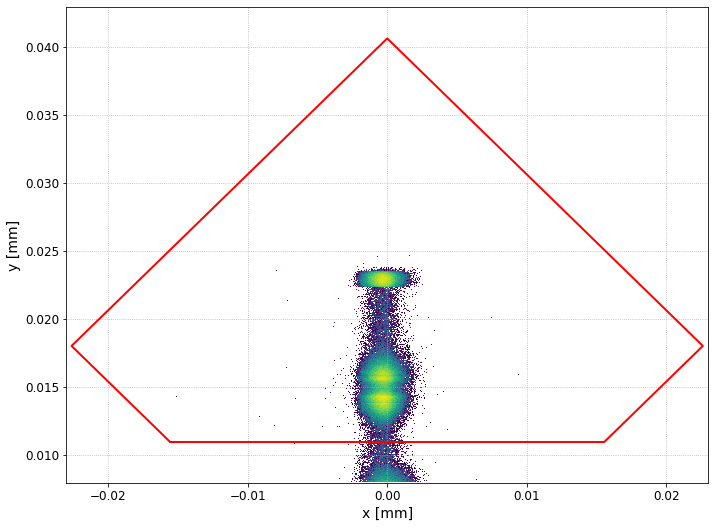

(1500, 1500)

In [ ]:
h_TFT = get_TFT_array(df_TFT, show_plot=True)[0]
h_TFT.shape

Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]


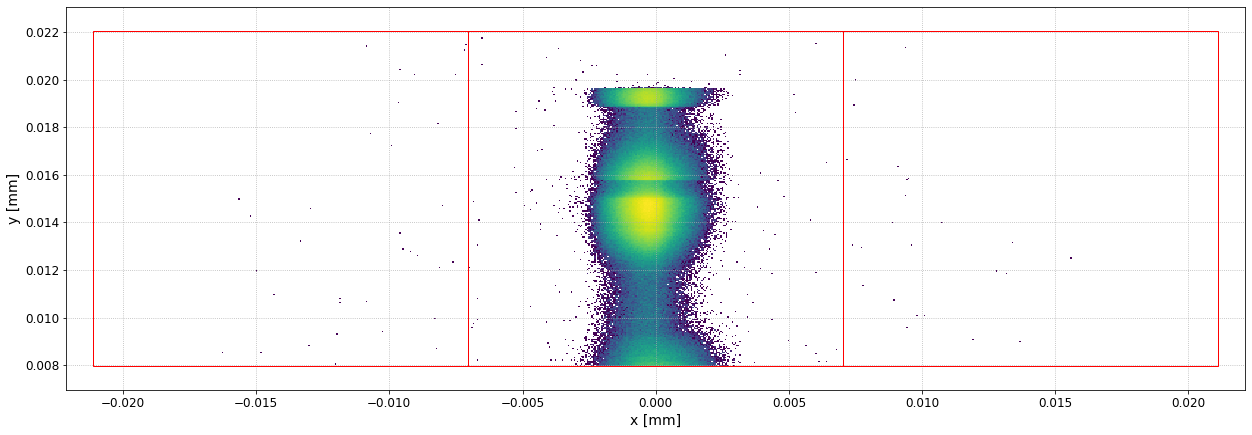

(768, 256)

In [47]:
h_PIX = get_PIX_array(df_PIX, show_plot=True)[0]
h_PIX.shape

In [80]:
TFT_data_to_plot = h_TFT
PIX_data_to_plot = h_PIX
print("TFT_data_to_plot shape: ", TFT_data_to_plot.shape)
print("PIX_data_to_plot shape: ", PIX_data_to_plot.shape)

TFT_data_to_plot shape:  (1500, 1500)
PIX_data_to_plot shape:  (768, 256)


Text(0, 0.5, 'y [mm]')

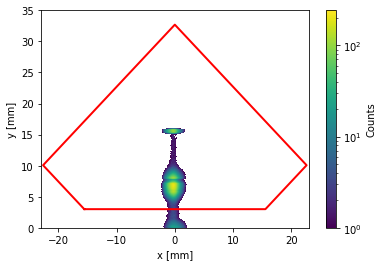

In [81]:
def get_pentagonal(y_lim = 0.003):
    angles = [180-135, 90, 90, 90,135] 
    side_lengths = [31.1e-3, 10e-3, 32e-3, 32e-3, 10e-3]  
    angles = np.radians(angles)

    ALFA_x = [0]
    ALFA_y = [0]
    for i in range(len(side_lengths)):
        angle_sum = np.sum(angles[:i])
        ALFA_x.append(ALFA_x[-1] + side_lengths[i] * np.cos(angle_sum))
        ALFA_y.append(ALFA_y[-1] + side_lengths[i] * np.sin(angle_sum))
    ALFA_x.append(ALFA_x[0])
    ALFA_y.append(ALFA_y[0])

    ALFA_x = [i -side_lengths[0]/2 for i in ALFA_x]
    ALFA_y = [i + y_lim for i in ALFA_y]

    return np.array(ALFA_x), np.array(ALFA_y)

fig, ax = plt.subplots()
xlim = (-23.0, 23.0)
ylim = (0.0, 35.0)
ALFA_x, ALFA_y = get_pentagonal()
ax.plot(ALFA_x*1e3, ALFA_y*1e3, color='r', lw=2)
cmap = plt.cm.viridis.copy()  
cmap.set_under('white')
norm = matplotlib.colors.LogNorm()

plt.imshow(TFT_data_to_plot.T, origin='lower', cmap=cmap, norm = norm,  extent=[xlim[0], xlim[1], ylim[0], ylim[1]], aspect='auto')  
plt.colorbar(label='Counts')
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')

In [82]:
np.sum(TFT_data_to_plot)

1105683.0

In [83]:
len(df_TFT)

1123916

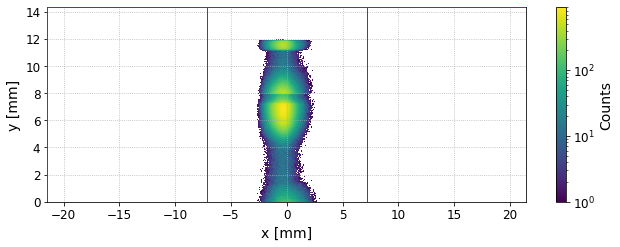

In [84]:
fig, ax = plt.subplots(figsize=(21.45/2,14.30/4))
def plot_rectangle( ax, x_low, x_up, y_low, y_up, zorder = 100, linewidth = 1, edgecolor = 'r', facecolor='none', alpha=1):
    rect = matplotlib.patches.Rectangle((x_low, y_low), x_up - x_low, y_up - y_low, edgecolor=edgecolor, facecolor=facecolor, alpha = alpha, zorder=zorder, linewidth=linewidth)
    ax.add_patch(rect)

ydim = 14.30
xdim = 21.45*2
abs_y_low =  0
abs_y_up = abs_y_low + ydim
abs_x_low = -xdim/2
abs_x_up = xdim/2
vmax, vmin = None, None
plot_rectangle(ax, abs_x_low, abs_x_low + xdim/3, abs_y_low, abs_y_up)
plot_rectangle(ax, abs_x_low + xdim/3, abs_x_low + xdim/3*2, abs_y_low, abs_y_up)
plot_rectangle(ax, abs_x_low + xdim/3*2, abs_x_up, abs_y_low, abs_y_up)

xlim = (-21.45, 21.45)
ylim = (0.0, 14.30)
cmap = plt.cm.viridis.copy()  
cmap.set_under('white')
norm = matplotlib.colors.LogNorm()
plt.imshow(PIX_data_to_plot.T, origin='lower', cmap=cmap, norm=norm, extent=[xlim[0], xlim[1], ylim[0], ylim[1]], aspect='auto')
cbar = plt.colorbar(ax=ax)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='Counts', fontsize=14)
ax.set_xlabel('x [mm]', fontsize=14)
ax.set_ylabel('y [mm]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(linestyle=":")

In [74]:
print(np.sum(PIX_data_to_plot))
print(len(df_PIX))

1132452.0
1132550


# In Beam

In [88]:
dc_files_path  = "./Outputdata/"

file_names_output = subprocess.check_output("ls " + dc_files_path, shell=True).decode('ascii').strip()


file_names_list = file_names_output.split()

path_list = []

for file_name in file_names_list:
    if file_name.startswith("InBeam"):
        file_path = os.path.join(dc_files_path, file_name)
        if os.path.exists(file_path):  
            path_list.append(file_path)

print(path_list) 
print("Number of files: ", len(path_list))

['./Outputdata/InBeam_450_TCCS_0.0.h5', './Outputdata/InBeam_450_TCCS_-11.0.h5', './Outputdata/InBeam_450_TCCS_11.0.h5', './Outputdata/InBeam_450_TCCS_-13.2.h5', './Outputdata/InBeam_450_TCCS_13.2.h5', './Outputdata/InBeam_450_TCCS_-15.4.h5', './Outputdata/InBeam_450_TCCS_15.4.h5', './Outputdata/InBeam_450_TCCS_-17.6.h5', './Outputdata/InBeam_450_TCCS_17.6.h5', './Outputdata/InBeam_450_TCCS_-19.8.h5', './Outputdata/InBeam_450_TCCS_19.8.h5', './Outputdata/InBeam_450_TCCS_-22.0.h5', './Outputdata/InBeam_450_TCCS_22.0.h5', './Outputdata/InBeam_450_TCCS_-2.2.h5', './Outputdata/InBeam_450_TCCS_2.2.h5', './Outputdata/InBeam_450_TCCS_-24.2.h5', './Outputdata/InBeam_450_TCCS_24.2.h5', './Outputdata/InBeam_450_TCCS_-26.4.h5', './Outputdata/InBeam_450_TCCS_-4.4.h5', './Outputdata/InBeam_450_TCCS_4.4.h5', './Outputdata/InBeam_450_TCCS_-6.6.h5', './Outputdata/InBeam_450_TCCS_6.6.h5', './Outputdata/InBeam_450_TCCS_-8.8.h5', './Outputdata/InBeam_450_TCCS_8.8.h5']
Number of files:  24


In [96]:
file_path[0]

'.'

In [97]:
df_TFT = pd.read_hdf(path_list[0], key="TFT_data")
df_PIX = pd.read_hdf(path_list[0], key="PIXEL_data")
metadata = pd.read_hdf(path_list[0], key="metadata")

Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]


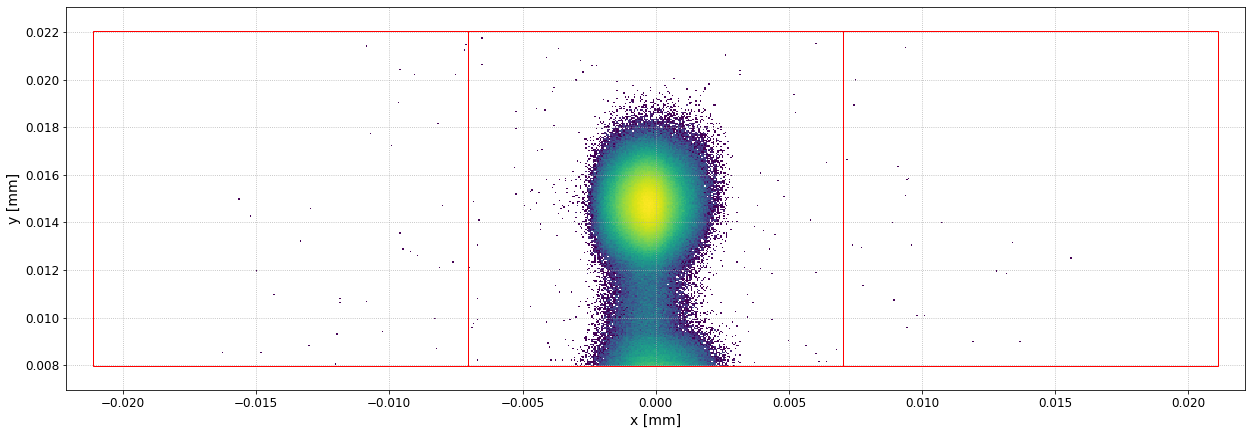

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [98]:
get_PIX_array(df_PIX, show_plot=True)[0]

Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]


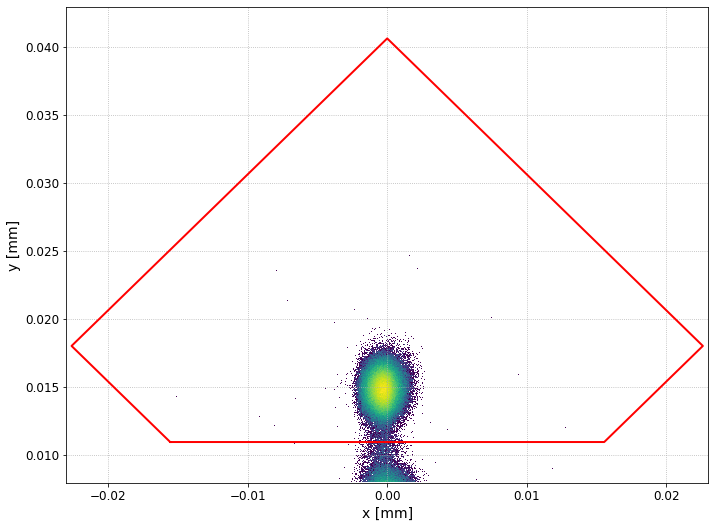

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [99]:
get_TFT_array(df_TFT, show_plot=True)[0]

In [100]:
metadata

,TCCS_align_angle,TCCS_absorbed
0,-0.000046,3222


In [101]:
output_hdf_path = "./TCCS_inBeam_450GeV_ANGSCAN.h5"
with pd.HDFStore(output_hdf_path, mode='w', complevel=9, complib='blosc') as store:
    for file_path in path_list:
        key = float(file_path.split("TCCS_")[1].split(".h5")[0])

        store_key = f"{str(key)}"
        print(f"Processing key: {key} → {store_key}")

        # Read data
        df_TFT = pd.read_hdf(file_path, key="TFT_data")
        df_PIX = pd.read_hdf(file_path, key="PIXEL_data")
        metadata = pd.read_hdf(file_path, key="metadata")
        TCCS_align_angle = metadata["TCCS_align_angle"].iloc[0]
        TCCS_absorbed = metadata["TCCS_absorbed"].iloc[0]

        # Compute arrays
        h_PIX = get_PIX_array(df_PIX, show_plot=False)[0]
        h_TFT = get_TFT_array(df_TFT, show_plot=False)[0]

        # Store arrays directly as DataFrames
        store.put(f"{store_key}/h_PIX", pd.DataFrame(h_PIX), format='table')
        store.put(f"{store_key}/h_TFT", pd.DataFrame(h_TFT), format='table')

        # Store scalar values as a one-row DataFrame
        scalars_df = pd.DataFrame({
            "TCCS_align_angle": [TCCS_align_angle],
            "TCCS_absorbed": [TCCS_absorbed]
        })
        store.put(f"{store_key}/metadata", scalars_df, format='table')

Processing key: 0.0 → 0.0
Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -11.0 → -11.0


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0.0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 11.0 → 11.0


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-11.0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -13.2 → -13.2


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '11.0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 13.2 → 13.2


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-13.2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -15.4 → -15.4


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '13.2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 15.4 → 15.4


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-15.4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -17.6 → -17.6


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '15.4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 17.6 → 17.6


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-17.6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -19.8 → -19.8


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '17.6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 19.8 → 19.8


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-19.8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -22.0 → -22.0


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '19.8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 22.0 → 22.0


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-22.0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -2.2 → -2.2


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '22.0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 2.2 → 2.2


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-2.2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -24.2 → -24.2


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2.2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 24.2 → 24.2


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-24.2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -26.4 → -26.4


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '24.2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -4.4 → -4.4


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-26.4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 4.4 → 4.4


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-4.4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -6.6 → -6.6


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '4.4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 6.6 → 6.6


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-6.6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: -8.8 → -8.8


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '6.6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]
Processing key: 8.8 → 8.8


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '-8.8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Retrieved bin width (X): [5.5e-05 0.0e+00]
Retrieved bin width (Y): [5.5e-05 0.0e+00]
Retrieved bin width (X): [3.06666667e-05 0.00000000e+00]
Retrieved bin width (Y): [3.06666667e-05 0.00000000e+00]


/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '8.8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


In [94]:
keys = [0.0, -11.0, 11.0, -13.2, 13.2, -15.4, 15.4, -17.6, 17.6, -19.8, 19.8, -22.0, 22.0, -2.2, 2.2, -24.2, 24.2, -26.4, -4.4, 4.4, -6.6, 6.6, -8.8, 8.8]

In [102]:
with pd.HDFStore(output_hdf_path, mode='r') as store:
    key = 11.0
  
    h_PIX = store[f"{key}/h_PIX"].values
    h_TFT = store[f"{key}/h_TFT"].values

    metadata = store[f"{key}/metadata"]
    TCCS_align_angle = metadata["TCCS_align_angle"].iloc[0]
    TCCS_absorbed = metadata["TCCS_absorbed"].iloc[0]

In [105]:
PIX_data_to_plot = h_PIX
TFT_data_to_plot = h_TFT

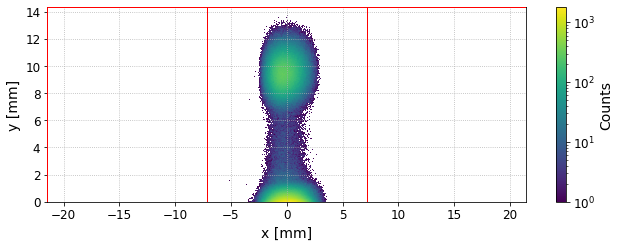

In [106]:
fig, ax = plt.subplots(figsize=(21.45/2,14.30/4))
def plot_rectangle( ax, x_low, x_up, y_low, y_up, zorder = 100, linewidth = 1, edgecolor = 'r', facecolor='none', alpha=1):
    rect = matplotlib.patches.Rectangle((x_low, y_low), x_up - x_low, y_up - y_low, edgecolor=edgecolor, facecolor=facecolor, alpha = alpha, zorder=zorder, linewidth=linewidth)
    ax.add_patch(rect)

ydim = 14.30
xdim = 21.45*2
abs_y_low =  0
abs_y_up = abs_y_low + ydim
abs_x_low = -xdim/2
abs_x_up = xdim/2
vmax, vmin = None, None
plot_rectangle(ax, abs_x_low, abs_x_low + xdim/3, abs_y_low, abs_y_up)
plot_rectangle(ax, abs_x_low + xdim/3, abs_x_low + xdim/3*2, abs_y_low, abs_y_up)
plot_rectangle(ax, abs_x_low + xdim/3*2, abs_x_up, abs_y_low, abs_y_up)

xlim = (-21.45, 21.45)
ylim = (0.0, 14.30)
cmap = plt.cm.viridis.copy()  
cmap.set_under('white')
norm = matplotlib.colors.LogNorm()
plt.imshow(PIX_data_to_plot.T, origin='lower', cmap=cmap, norm=norm, extent=[xlim[0], xlim[1], ylim[0], ylim[1]], aspect='auto')
cbar = plt.colorbar(ax=ax)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='Counts', fontsize=14)
ax.set_xlabel('x [mm]', fontsize=14)
ax.set_ylabel('y [mm]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(linestyle=":")

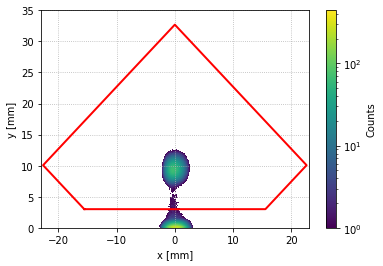

In [108]:
def get_pentagonal(y_lim = 0.003):
    angles = [180-135, 90, 90, 90,135] 
    side_lengths = [31.1e-3, 10e-3, 32e-3, 32e-3, 10e-3]  
    angles = np.radians(angles)

    ALFA_x = [0]
    ALFA_y = [0]
    for i in range(len(side_lengths)):
        angle_sum = np.sum(angles[:i])
        ALFA_x.append(ALFA_x[-1] + side_lengths[i] * np.cos(angle_sum))
        ALFA_y.append(ALFA_y[-1] + side_lengths[i] * np.sin(angle_sum))
    ALFA_x.append(ALFA_x[0])
    ALFA_y.append(ALFA_y[0])

    ALFA_x = [i -side_lengths[0]/2 for i in ALFA_x]
    ALFA_y = [i + y_lim for i in ALFA_y]

    return np.array(ALFA_x), np.array(ALFA_y)

fig, ax = plt.subplots()
xlim = (-23.0, 23.0)
ylim = (0.0, 35.0)
ALFA_x, ALFA_y = get_pentagonal()
ax.plot(ALFA_x*1e3, ALFA_y*1e3, color='r', lw=2)
cmap = plt.cm.viridis.copy()  
cmap.set_under('white')
norm = matplotlib.colors.LogNorm()

plt.imshow(TFT_data_to_plot.T, origin='lower', cmap=cmap, norm = norm,  extent=[xlim[0], xlim[1], ylim[0], ylim[1]], aspect='auto')  
plt.colorbar(label='Counts')
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.grid(linestyle=":")

# TCLA abs

In [16]:
df = pd.read_hdf("./Outputdata/Double_Channeling_450_ABSORBED_2.h5", key = "absorbed" )

In [17]:
df

,delta_angle_TCCP,TCCS_abs,TCCP_abs,TCLA_abs,PIPE_abs,TCCP_angle,npart,n_impacts
0,-0.0,3222,83176,546692,287605,0.000170,2000000,1132550
1,-1.1,3221,82947,545438,289829,0.000169,2000000,1132776
2,-11.0,3221,93402,602041,198523,0.000159,2000000,1122326
3,-12.1,3221,96156,614684,175470,0.000158,2000000,1119575
4,-13.2,3222,99183,627341,151734,0.000156,2000000,1116544
5,-14.3,3221,101989,639399,128532,0.000155,2000000,1113744
6,-15.4,3222,104838,650678,105843,0.000154,2000000,1110901
7,-16.5,3221,107630,661117,84379,0.000153,2000000,1108109
8,-17.6,3223,110173,670657,64496,0.000152,2000000,1105571
9,-18.7,3221,112299,678953,46536,0.000151,2000000,1103453


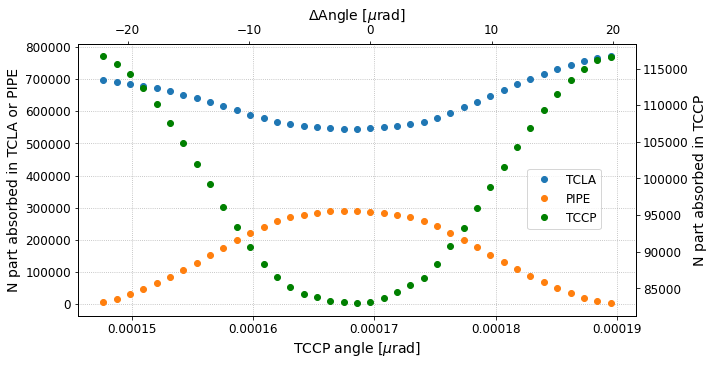

In [49]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.TCCP_angle, df.TCLA_abs, 'o', label = "TCLA")
ax.plot(df.TCCP_angle, df.PIPE_abs, 'o', label = "PIPE")
ax2 = ax.twinx()
ax2.plot(df.TCCP_angle, df.TCCP_abs, 'o', color = "green", label = "TCCP")
ax2.set_ylabel("N part absorbed in TCCP", fontsize=14)
ax.set_xlabel("TCCP angle [$\mu$rad]", fontsize=14)
ax.set_ylabel("N part absorbed in TCLA or PIPE", fontsize=14)
ax3  = ax.twiny()
ax3.plot(df.delta_angle_TCCP, df.TCLA_abs, 'o', alpha=0)
ax3.set_xlabel("$\Delta$Angle [$\mu$rad]", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax3.tick_params(axis='both', which='major', labelsize=12)
# Get handles and labels for both axes' legends
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
fig.legend(handles1 + handles2, labels1 + labels2, loc='upper center', fontsize=12,  bbox_to_anchor=(0.80, 0.55))
ax.grid(linestyle=":")



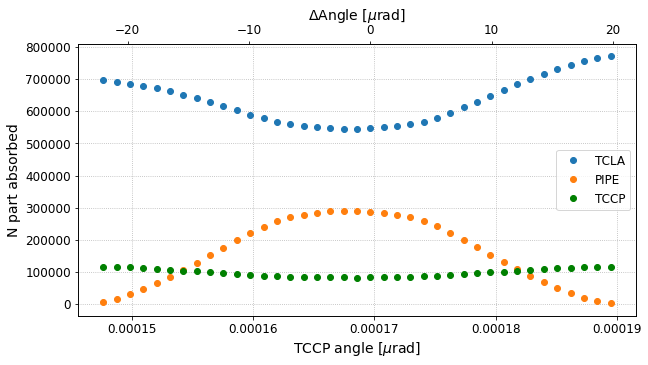

In [54]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.TCCP_angle, df.TCLA_abs, 'o', label = "TCLA")
ax.plot(df.TCCP_angle, df.PIPE_abs, 'o', label = "PIPE")

ax.plot(df.TCCP_angle, df.TCCP_abs, 'o', color = "green", label = "TCCP")

ax.set_xlabel("TCCP angle [$\mu$rad]", fontsize=14)
ax.set_ylabel("N part absorbed", fontsize=14)
ax3  = ax.twiny()
ax3.plot(df.delta_angle_TCCP, df.TCLA_abs, 'o', alpha=0)
ax3.set_xlabel("$\Delta$Angle [$\mu$rad]", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

ax3.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12)
ax.grid(linestyle=":")

# Test New Script

In [19]:
with pd.HDFStore("./DoubleChanneling_450GeV_ANGSCAN_test.h5", mode='r') as store:
    key = -0.0
  
    h_PIX = store[f"{key}/h_PIX"].values
    h_TFT = store[f"{key}/h_TFT"].values



In [20]:
PIX_data_to_plot = h_PIX
TFT_data_to_plot = h_TFT

In [23]:
np.sum(PIX_data_to_plot)

5689.0

In [24]:
np.sum(TFT_data_to_plot)

5656.0

Text(0, 0.5, 'y [mm]')

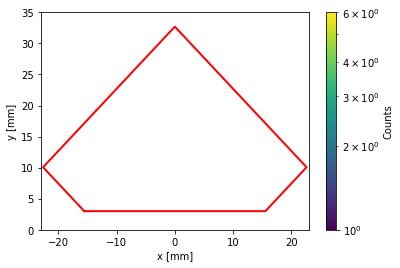

In [26]:
def get_pentagonal(y_lim = 0.003):
    angles = [180-135, 90, 90, 90,135] 
    side_lengths = [31.1e-3, 10e-3, 32e-3, 32e-3, 10e-3]  
    angles = np.radians(angles)

    ALFA_x = [0]
    ALFA_y = [0]
    for i in range(len(side_lengths)):
        angle_sum = np.sum(angles[:i])
        ALFA_x.append(ALFA_x[-1] + side_lengths[i] * np.cos(angle_sum))
        ALFA_y.append(ALFA_y[-1] + side_lengths[i] * np.sin(angle_sum))
    ALFA_x.append(ALFA_x[0])
    ALFA_y.append(ALFA_y[0])

    ALFA_x = [i -side_lengths[0]/2 for i in ALFA_x]
    ALFA_y = [i + y_lim for i in ALFA_y]

    return np.array(ALFA_x), np.array(ALFA_y)

fig, ax = plt.subplots()
xlim = (-23.0, 23.0)
ylim = (0.0, 35.0)
ALFA_x, ALFA_y = get_pentagonal()
ax.plot(ALFA_x*1e3, ALFA_y*1e3, color='r', lw=2)
cmap = plt.cm.viridis.copy()  
cmap.set_under('white')
norm = matplotlib.colors.LogNorm()

plt.imshow(TFT_data_to_plot.T, origin='lower', cmap=cmap, norm = norm,  extent=[xlim[0], xlim[1], ylim[0], ylim[1]], aspect='auto')  
plt.colorbar(label='Counts')
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')

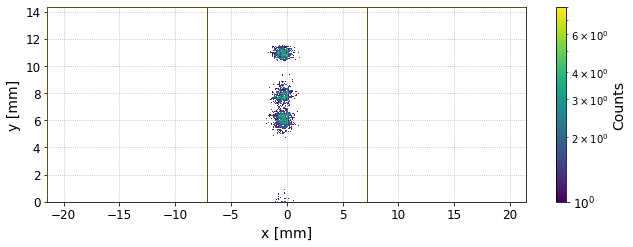

In [22]:
fig, ax = plt.subplots(figsize=(21.45/2,14.30/4))
def plot_rectangle( ax, x_low, x_up, y_low, y_up, zorder = 100, linewidth = 1, edgecolor = 'r', facecolor='none', alpha=1):
    rect = matplotlib.patches.Rectangle((x_low, y_low), x_up - x_low, y_up - y_low, edgecolor=edgecolor, facecolor=facecolor, alpha = alpha, zorder=zorder, linewidth=linewidth)
    ax.add_patch(rect)

ydim = 14.30
xdim = 21.45*2
abs_y_low =  0
abs_y_up = abs_y_low + ydim
abs_x_low = -xdim/2
abs_x_up = xdim/2
vmax, vmin = None, None
plot_rectangle(ax, abs_x_low, abs_x_low + xdim/3, abs_y_low, abs_y_up)
plot_rectangle(ax, abs_x_low + xdim/3, abs_x_low + xdim/3*2, abs_y_low, abs_y_up)
plot_rectangle(ax, abs_x_low + xdim/3*2, abs_x_up, abs_y_low, abs_y_up)

xlim = (-21.45, 21.45)
ylim = (0.0, 14.30)
cmap = plt.cm.viridis.copy()  
cmap.set_under('white')
norm = matplotlib.colors.LogNorm()
plt.imshow(PIX_data_to_plot.T, origin='lower', cmap=cmap, norm=norm, extent=[xlim[0], xlim[1], ylim[0], ylim[1]], aspect='auto')
cbar = plt.colorbar(ax=ax)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='Counts', fontsize=14)
ax.set_xlabel('x [mm]', fontsize=14)
ax.set_ylabel('y [mm]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(linestyle=":")

In [27]:
df = pd.read_hdf("./Outputdata/Double_Channeling_450_ABSORBED_test.h5", key = "absorbed" )

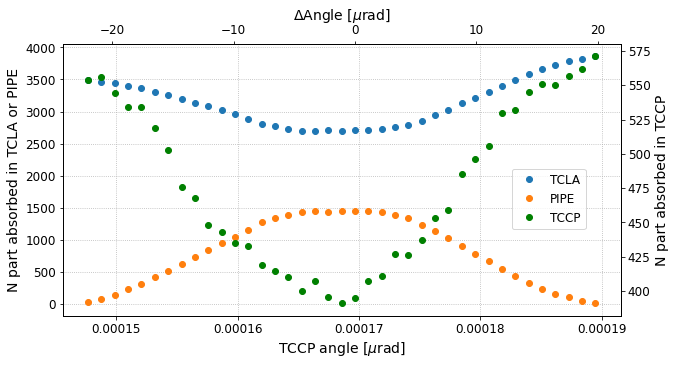

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.TCCP_angle, df.TCLA_abs, 'o', label = "TCLA")
ax.plot(df.TCCP_angle, df.PIPE_abs, 'o', label = "PIPE")
ax2 = ax.twinx()
ax2.plot(df.TCCP_angle, df.TCCP_abs, 'o', color = "green", label = "TCCP")
ax2.set_ylabel("N part absorbed in TCCP", fontsize=14)
ax.set_xlabel("TCCP angle [$\mu$rad]", fontsize=14)
ax.set_ylabel("N part absorbed in TCLA or PIPE", fontsize=14)
ax3  = ax.twiny()
ax3.plot(df.delta_angle_TCCP, df.TCLA_abs, 'o', alpha=0)
ax3.set_xlabel("$\Delta$Angle [$\mu$rad]", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax3.tick_params(axis='both', which='major', labelsize=12)
# Get handles and labels for both axes' legends
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
fig.legend(handles1 + handles2, labels1 + labels2, loc='upper center', fontsize=12,  bbox_to_anchor=(0.80, 0.55))
ax.grid(linestyle=":")
